<a href="https://colab.research.google.com/github/rgerraty/hybrid_reinforcement_learning/blob/master/Updated_Moving_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import imageio
import test as test

In [0]:
# Class that creates random moving MNIST image dataset on the fly (15 time steps x [100 batches x 1 x 64 x 64])
class MovingMNIST(object):

    def __init__(self, train, data_root, seq_len, num_digits, image_size, deterministic):
        path = data_root
        self.seq_len = seq_len
        self.num_digits = num_digits  
        self.image_size = image_size
        self.step_length = 0.1
        self.digit_size = 32
        self.deterministic = deterministic
        self.seed_is_set = False # multi threaded loading
        self.channels = 1 

        self.data = datasets.MNIST(
            path,
            train=train,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(self.digit_size),
                 transforms.ToTensor()]))

        self.N = len(self.data) 

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        self.set_seed(index)
        image_size = self.image_size
        digit_size = self.digit_size
        x = np.zeros((self.seq_len,
                      image_size, 
                      image_size, 
                      self.channels),
                    dtype=np.float32)
        for n in range(self.num_digits):
            idx = np.random.randint(self.N)
            digit, _ = self.data[idx]

            sx = np.random.randint(image_size-digit_size)
            sy = np.random.randint(image_size-digit_size)
            dx = np.random.randint(-4, 5)
            dy = np.random.randint(-4, 5)
            for t in range(self.seq_len):
                if sy < 0:
                    sy = 0 
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(1, 5)
                        dx = np.random.randint(-4, 5)
                elif sy >= image_size-32:
                    sy = image_size-32-1
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(-4, 0)
                        dx = np.random.randint(-4, 5)
                    
                if sx < 0:
                    sx = 0 
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(1, 5)
                        dy = np.random.randint(-4, 5)
                elif sx >= image_size-32:
                    sx = image_size-32-1
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(-4, 0)
                        dy = np.random.randint(-4, 5)

                x[t, sy:sy+32, sx:sx+32, 0] += digit.numpy().squeeze()
                sy += dy
                sx += dx

        x[x>1] = 1.
        return x

In [0]:
data_root = 'data'
n_past = 5
n_future = 10
n_time = n_past + n_future
image_width = 64
num_digits = 2

# Creates two MovingMNIST objects, each representing a train/test dataset
def load_dataset():
    train_data = MovingMNIST(
            train=True,
            data_root=data_root,
            seq_len=n_time,
            image_size=image_width,
            deterministic=False,
            num_digits=num_digits)
    test_data = MovingMNIST(
            train=False,
            data_root=data_root,
            #seq_len=n_eval,
            seq_len=n_time,
            image_size=image_width,
            deterministic=False,
            num_digits=num_digits)
    return train_data, test_data

In [0]:
# Saves two Moving MNIST dataset objects
train_data, test_data = load_dataset()

In [0]:
data_threads = 5
batch_size = 100


# Creates two DataLoader objects from the Moving MNIST dataset objects
train_loader = DataLoader(train_data,
                          num_workers=data_threads,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                         num_workers=data_threads,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True,
                         pin_memory=True)

In [0]:
# Used to change data from numpy array to tensor
dtype = torch.cuda.FloatTensor

# Changes numpy sequence arrays to tensor arrays
def sequence_input(seq, dtype):
    return [Variable(x.type(dtype)) for x in seq]

# Fixes ordering of array by transposing dimensions
def normalize_data(dtype, sequence):
    sequence.transpose_(0, 1)
    sequence.transpose_(3, 4).transpose_(2, 3)
    
    return sequence_input(sequence, dtype)

In [0]:
# Creates a training batch for each sequence in the training DataLoader
def get_training_batch():
    while True:
        for sequence in train_loader:
            batch = normalize_data(dtype, sequence)
            yield batch

# Creates a testing batch for each sequence in the testing DataLoader
def get_testing_batch():
    while True:
        for sequence in test_loader:
            batch = normalize_data(dtype, sequence)
            yield batch

In [0]:
# Creates two batch generator objects with each output of size 15 x [100,1,64,64]
training_batch_generator = get_training_batch()
testing_batch_generator = get_testing_batch()
# Run cell twice if error text pops up

In [0]:
# Switches to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Calculates and returns random sample from the distribution of latent parameters z_mu (mean) and z_logsigma (variance)
def create_z_sample(z_mu,z_logsigma):
    z_sigma = torch.exp(z_logsigma)
    eps = torch.randn_like(z_sigma)
    z_sample = eps.mul(z_sigma).add_(z_mu)
    return z_sample

In [0]:
# Class that creates convolutional recurrent neural network model
class VAE(nn.Module):
  def __init__(self, enc, dec, rnn):
    super().__init__()
    
    self.enc = enc
    self.dec = dec
    self.rnn = rnn
  
  def forward(self, x, hidden):
    # Returns latent space output of encoder
    z_dim = self.enc(x)
        
    # Returns outputs of latent space rnn 
    z_mu, z_logsigma, hidden = self.rnn(z_dim,hidden)
    
    # Returns predicted sample from predicted distribution
    z_pred = create_z_sample(z_mu,z_logsigma)
    
    # Returns image output of decoder
    predicted = self.dec(z_pred)
        
    return predicted, z_mu, z_logsigma, hidden

  # Calls method in rnn that initializes hidden state of rnn and creates new weights
  def rnn_hidden(self,batch_size):
    return self.rnn.init_hidden(batch_size)

In [0]:
# Class that creates encoder model to transform input into latent space
class Encoder(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(16)
    self.conv2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn2=nn.BatchNorm2d(32)
    self.conv3=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn3=nn.BatchNorm2d(64)
    self.conv4=nn.Conv2d(64,16,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn4=nn.BatchNorm2d(16)
    
    self.fc1 = nn.Linear(16 * 16 * 16, z_dim)
    self.fc_bn1 = nn.BatchNorm1d(z_dim)
    
    
  def forward(self, x):
    conv1=nn.functional.relu(self.bn1(self.conv1(x)))
    conv2=nn.functional.relu(self.bn2(self.conv2(conv1)))
    conv3=nn.functional.relu(self.bn3(self.conv3(conv2)))
    conv4=nn.functional.relu(self.bn4(self.conv4(conv3))).view(-1, 16 * 16 * 16)
    fc1=nn.functional.relu(self.fc_bn1(self.fc1(conv4)))
    # Makes encoder output 3-dimensional so that it can pass through LSTM (now [100x1x10]) 
    fc1 = fc1.unsqueeze(1) 
    return fc1
    

In [0]:
# Class that creates rnn model to predict latent space distribution
class RNN(nn.Module):
  def __init__(self, z_dim, n_hidden, n_layers=1, drop_prob=0.5, lr=0.001):
    super().__init__()
    
    # Saves input size, which is the same size as the latent space
    self.z_dim = z_dim
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_prob = drop_prob
    self.lr = lr
    
    # Creates LSTM cell that takes in input size, hidden state features, and sets tensors to put batch_size first)
    self.lstm = nn.LSTM(self.z_dim, n_hidden, batch_first=True)

    # Creates dropout layer on outputs of LSTM
    self.dropout = nn.Dropout(drop_prob)
    
    # Creates final Linear layers that produce outputs z_mu and z_logsigma from input of size z_dim
    self.z_mu = nn.Linear(n_hidden,self.z_dim)
    self.z_logsigma = nn.Linear(n_hidden, self.z_dim)

    
  def forward(self,x,hidden):
    # Returns output ([100x1x20]) and hidden state of LSTM taking in input ([100x1x10]) and previous hidden state
    z_output, hidden = self.lstm(x, hidden)   
    # Returns output of dropout layer
    out = self.dropout(z_output) 
    # Returns output of z_mu Linear layer
    z_mu = self.z_mu(out)
    # Returns output of z_logsigma Linear layer
    z_logsigma = self.z_logsigma(out) 
    return z_mu, z_logsigma, hidden

  
  # Initializes hidden state of rnn and creates new weights
  def init_hidden(self,batch_size):
    weight = next(self.parameters()).data
    # 1 x 100 x 20
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(), weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    return hidden

In [0]:
# Class that creates decoder model to transform the predicted latent space distribution into a predicted image
class Decoder(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.fc2=nn.Linear(z_dim,z_dim)
    self.fc_bn2=nn.BatchNorm1d(z_dim)
    self.fc3=nn.Linear(z_dim,16*16*16) #changed
    self.fc_bn3=nn.BatchNorm1d(16*16*16) #changed
    self.dconv5=nn.ConvTranspose2d(16,64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False)
    self.bn5=nn.BatchNorm2d(64)
    self.dconv6=nn.ConvTranspose2d(64,32,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn6=nn.BatchNorm2d(32)
    self.dconv7=nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False)
    self.bn7=nn.BatchNorm2d(16)
    self.dconv8=nn.ConvTranspose2d(16,1,kernel_size=3,stride=1,padding=1,bias=False)
    
  def forward(self, z_sample):
    # Makes the input 2-dimensional again so that it can pass through the deconvolutional layers (now [100x10]) 
    z_sample = z_sample.squeeze(1) 
    fc2=nn.functional.relu(self.fc_bn2(self.fc2(z_sample)))
    fc3=nn.functional.relu(self.fc_bn3(self.fc3(fc2))).view(-1, 16, 16 , 16)
    dconv5=nn.functional.relu(self.bn5(self.dconv5(fc3)))
    dconv6=nn.functional.relu(self.bn6(self.dconv6(dconv5)))
    dconv7=nn.functional.relu(self.bn7(self.dconv7(dconv6)))
    predicted=self.dconv8(dconv7)
        
    return predicted

In [0]:
# Class that creates the loss function that calculates loss of the model
class Loss(nn.Module):
  def __init__(self):
    super(Loss,self).__init__()
    self.recon_loss=nn.MSELoss(reduction="sum")
    
  def forward(self,recon_x,x,mu,logsigma):
    recon_loss=self.recon_loss(recon_x,x)
    KLD=-.5 * torch.sum(-1+2*logsigma-mu.pow(2)-(logsigma.exp())**2)
    
    return recon_loss+KLD


In [0]:
# Size of latent space
z_dim=10

# Initializes three parts of model, as well as the model itself
encoder=Encoder(z_dim)
decoder=Decoder(z_dim)
rnn = RNN(z_dim,20)
model=VAE(encoder,decoder,rnn).to(device)

# Creates the optimizer and initializes the loss function
optimizer=optim.Adam(model.parameters(),lr=1e-3)
loss_=Loss()

seed = 1

train_losses = []
val_losses = []

In [0]:
# Displays image
def show(image):
    image = image.cpu()
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image), interpolation='nearest')      

In [0]:
# Trains model for each epoch
def train(x,epoch,train_size): 
    model.train()
    train_loss = 0
    # Initializes hidden state
    hidden = model.rnn_hidden(batch_size)
    model.zero_grad()
    optimizer.zero_grad()
    # Loops through 15 time steps
    for time in range(0,n_time-1):
        # Batch at time t (used for training)
        data = x[time].to(device)
        # Batch at time t+1 (used to calculate reconstruction loss)
        target = x[time+1].to(device)
        hidden = tuple([each.data for each in hidden])
        # Returns outputs of model
        recon_batch, mu, logsigma, hidden = model(data,hidden)
        # Returns reconstruction loss
        loss = loss_(recon_batch, target, mu, logsigma)
        # Calculates gradient
        loss.backward()
        train_loss += loss.item()
        # Optimizes parameters
        optimizer.step()
        
    train_loss /= train_size
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    train_losses.append(train_loss)

In [0]:
def test(y,epoch,test_size):
    model.eval()
    test_loss = 0
    # Initializes hidden state
    hidden = model.rnn_hidden(batch_size)
    with torch.no_grad():
        # Loops through 15 time steps
        for time in range(0,n_time-1):
            # Batch at time t (used for testing)
            data = y[time].to(device)
            # Batch at time t+1 (used to calculate reconstruction loss)
            target = y[time+1].to(device)
            hidden = tuple([each.data for each in hidden])
            # Returns outputs of model
            recon_batch, mu, logsigma, hidden = model(data,hidden)
            # Returns reconstruction loss
            test_loss += loss_(recon_batch, target, mu, logsigma).item()
                
    test_loss /= test_size
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

====> Epoch: 0 Average loss: 1177.4070
====> Test set loss: 217.3529
====> Epoch: 0 Average loss: 485.8011
====> Test set loss: 301.3097
====> Epoch: 0 Average loss: 511.8778
====> Test set loss: 424.6139
====> Epoch: 0 Average loss: 584.5063
====> Test set loss: 428.4787
====> Epoch: 0 Average loss: 426.5179
====> Test set loss: 414.1768
====> Epoch: 0 Average loss: 415.3839
====> Test set loss: 267.9256
====> Epoch: 0 Average loss: 280.9224
====> Test set loss: 308.7571
====> Epoch: 0 Average loss: 275.5430
====> Test set loss: 243.2179
====> Epoch: 0 Average loss: 234.4564
====> Test set loss: 243.8062
====> Epoch: 0 Average loss: 238.8287
====> Test set loss: 223.8885
====> Epoch: 0 Average loss: 221.4150
====> Test set loss: 230.7930
====> Epoch: 0 Average loss: 219.0386
====> Test set loss: 206.7495
====> Epoch: 0 Average loss: 215.1644
====> Test set loss: 200.4909
====> Epoch: 0 Average loss: 214.2352
====> Test set loss: 205.8838
====> Epoch: 0 Average loss: 202.4960
====> Tes

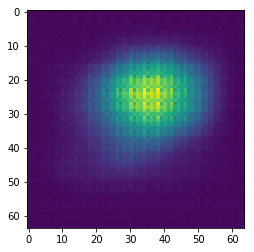

In [0]:
num_epochs = 5
epoch_size = 50
size = (n_time-1)*batch_size

# Iterates through the number of epochs
for epoch in range(num_epochs):
    # Iterates through the steps in an epoch
    for step in range(epoch_size):
        # Returns a training batch for training 
        x = next(training_batch_generator)
        train(x,epoch,size)
        # Returns a testing batch for testing
        y = next(testing_batch_generator)
        test(y,epoch,size)
    
    # Finds a sample in the trained latent space and displays the corresponding dream image
    with torch.no_grad():
        sample_z = torch.randn(100, z_dim).to(device) #64
        sample = model.dec(sample_z).cpu()
    show(sample[0,0,:,:])

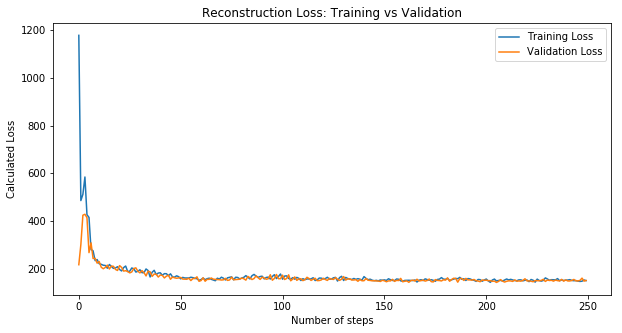

In [0]:
plt.figure(figsize=(10,5))

plt.plot(train_losses,label="Training Loss")
plt.plot(val_losses,label="Validation Loss")
plt.title("Reconstruction Loss: Training vs Validation")
plt.xlabel("Number of steps")
plt.ylabel("Calculated Loss")
plt.legend()

plt.show()

In [0]:
# Returns an image over 15 time steps from 100 possible images in the batch
def make_data(input,batch_num):
    data = []
    for i in range(len(input)):
        image = input[i][batch_num,0,:,:]
        image = expand_dims(image)
        data.append(image)
    return data

# Adds two dimensions to the image to make it 4D [1x1x64x64]
def expand_dims(image):
    image = image[None, None, :, :]
    return image

# Removes two dimensions of the image to make it 2D [64x64]
def reduce_dims(image):
    image = image.view(64,-1)
    return image

In [0]:
# Creates new images that predict how image will change over time steps
def predict_image(data, hidden):
    image_over_time = []
    with torch.no_grad():
        for time in range(0,len(data)):
            image = data[time].to(device)
            hidden = tuple([each.data for each in hidden])
            recon_image, _, _, hidden = model(image,hidden)
            recon_image = reduce_dims(recon_image)
            image_over_time.append(recon_image)
    return image_over_time, hidden
      
    
# Inputs data to predict how Moving MNINST changes
def predict_MMNIST():
    pred_set = next(testing_batch_generator)
    original_images = make_data(pred_set,0)
    image_over_time, hidden = predict_image(original_images[0:n_time-1], model.rnn_hidden(1))
    # returns predicted and original images
    return image_over_time, original_images

In [0]:
# Creates gif out of set of images over time
def create_gif(images,name):
    gif = []
    for image in images:
        image = reduce_dims(image)
        image = image.cpu().numpy()
        gif.append(image)
    imageio.mimsave('/content/{}.gif'.format(name), gif)

In [0]:
predicted, original = predict_MMNIST()

create_gif(predicted,'Predicted')
create_gif(original,'Original')

In [0]:
# Download MovingMNIST gif for viewing
from google.colab import files
files.download('Original.gif')
files.download('Predicted.gif')

In [0]:
# Use to check gif locally in colab
!ls /content

from PIL import Image
image = Image.open('Predicted.gif')

image